In [3]:
# Imports

import os
import re
import gzip
import pandas as pd
import numpy as np

# Data Container and Analysis
import anndata as ad
import scanpy as sc
import squidpy as sq

# R Integration for BayesSpace Clustering
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import set_conversion 
import anndata2ri
import rpy2.robjects.numpy2ri

# Registers the AnnData converter globally
set_conversion(anndata2ri.converter + rpy2.robjects.numpy2ri.converter)

# Machine Learning and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

# CellPLM
from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline

# Environment Configuration (CUDA check)
import torch
if not torch.cuda.is_available():
    torch_load_old = torch.load
    def torch_load_cpu(*args, **kwargs):
        kwargs['map_location'] = torch.device('cpu')
        return torch_load_old(*args, **kwargs)
    torch.load = torch_load_cpu
    print("Running on CPU mode (CUDA not available).")

/Users/jleto/Library/Python/3.12/lib/python/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/jleto/Library/Python/3.12/lib/python/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")
/Users/jleto/Library/Python/3.12/lib/python/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
Error importing in API mode: ImportError("dlopen(/Users/jleto/Library/Python/3.12/lib/python/site-packages/_rinterfa

Running on CPU mode (CUDA not available).


### 1. Gene Expression Data Loading and Merging  

This section loads all spatial transcriptomics files and merges them into one unified gene expression matrix for better downstream analysis.  

The dataset is provided as multiple files, each representing a separate **Visium spatial transcriptomics slide**. Each slide captures **RNA expression patterns** across a thin physical **tissue section**.

These RNA expression patterns show which genes are active and how strongly in different parts of the tissue,  since when a cell uses a gene, it produces mRNA copies of it, *that* is gene expression.

With this technique, RNA molecules released from the tissue bind to barcoded capture spots printed on the slide.  
Each spot records which genes were expressed, basically turning the slide into a grid of thousands of tiny RNA "sensors".  

Because each Visium slide can only capture a limited physical area, the process must be repeated for new sections of tissue, so the dataset comes as multiple files, one for each physical slide (or tissue section).  

Each .txt.gz file contains a **gene expression matrix** for its slide:  
- **Rows** represent genes.  
- **Columns** represent spatial spots (barcoded capture locations on the slide).  
- Each value shows how much RNA from that gene was detected at that spot.  

Each file will be loaded as an AnnData object. The cells below will handle file paths, load counts and coordinates, enforce alignment, and create one single AnnData object for the entire multi-sample dataset.

In [4]:
# Load and Inspect Gene Expression Matrices

import os
import pandas as pd
from IPython.display import display

# Configuration
data_dir = "GSE253975_data"

# Check Directory Contents
print(f"Checking Directory: {data_dir}")

try:
    all_files = [f for f in os.listdir(data_dir) if not f.startswith('.')]
    print(f"Total files found: {len(all_files)}")
    print(all_files)
    
    # Filter only for matrix text files
    txt_files = [f for f in all_files if f.endswith('.txt.gz')]
    print(f"Txt files found: {len(txt_files)}")
    print(txt_files)
    
    if not txt_files:
        print("No .txt.gz files found.")
    else:
        # Pick the first file to test
        test_file = txt_files[0]
        print(f"\n Inspecting First File: {test_file}")
        file_path = os.path.join(data_dir, test_file)

        try:
            df = pd.read_csv(file_path, sep=r'\s+', index_col=0, nrows=5, engine='python') # r'\s+' handles single spaces, tabs, or multiple spaces
            
            print(f"Shape: {df.shape}")
            print(f"Columns (First 5): {list(df.columns)[:5]}")
            
            # Display head for visual check
            print("\nHead of data:")
            display(df.head(2))
            
        except Exception as e:
            print(f"Error reading file: {e}")

except FileNotFoundError:
    print(f"Directory '{data_dir}' not found.")

Checking Directory: GSE253975_data
Total files found: 19
['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']
Txt files found: 9
['GSM8031369_T2465.txt.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031365_T4839.txt.gz']

 Inspecting First File: GSM8031369_T2465.txt.gz
Shape: (5, 958)
Columns (First 5): ['

,"""T2465_AAACCGTTCGTCCAGG.1""","""T2465_AAACGAGACGGTTGAT.1""","""T2465_AAACTGCTGGCTCCAA.1""","""T2465_AAAGGCTCTCGCGCCG.1""","""T2465_AAAGGGATGTAGCAAG.1""","""T2465_AAATACCTATAAGCAT.1""","""T2465_AAATCGTGTACCACAA.1""","""T2465_AAATGGTCAATGTGCC.1""","""T2465_AAATTAACGGGTAGCT.1""","""T2465_AAATTTGCGGGTGTGG.1""",...,"""T2465_TTGTAAGGACCTAAGT.1""","""T2465_TTGTAAGGCCAGTTGG.1""","""T2465_TTGTAATCCGTACTCG.1""","""T2465_TTGTCGTTCAGTTACC.1""","""T2465_TTGTGTATGCCACCAA.1""","""T2465_TTGTGTTTCCCGAAAG.1""","""T2465_TTGTTAGCAAATTCGA.1""","""T2465_TTGTTCAGTGTGCTAC.1""","""T2465_TTGTTGTGTGTCAAGA.1""","""T2465_TTGTTTCACATCCAGG.1"""
"""MIR1302-2HG""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""FAM138A""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Load Individual Gene Expression Matrices Into a Combined AnnData Master Expression Matrix

# Extract unique sample IDs for tracking
sample_ids = sorted(list(set([f.split('_')[0] for f in txt_files])))
print(f"Found {len(sample_ids)} samples: {sample_ids}")

adatas = []

for sample in sample_ids:
    # Find the text file for this sample
    sample_file = [f for f in txt_files if f.startswith(sample)][0]
    file_path = os.path.join(data_dir, sample_file)
    
    print(f"Loading expression matrix: {sample_file}...")
    
    try:
        # Load Data
        df_counts = pd.read_csv(file_path, sep=r'\s+', index_col=0, engine='python')
        
        # Create AnnData Object
        # Transpose (.T) is required because AnnData expects Rows=Spots, Cols=Genes
        adata = sc.AnnData(df_counts.T)
        
        if adata.n_obs == 0:
            print(f"Skipping {sample}: Matrix is empty.")
            continue
            
        # Add Metadata so we can split them apart later if needed
        adata.obs['sample_id'] = sample
        
        adatas.append(adata)
        
    except Exception as e:
        print(f"Error loading {sample}: {e}")

# Combine into One Unified Matrix
if adatas:
    # Merge all spots and keeps all genes (outer join)
    adata = ad.concat(adatas, label='batch', keys=sample_ids, join='outer')
    
    # Optimize by converting to sparse matrix
    from scipy import sparse
    if not sparse.issparse(adata.X):
        adata.X = sparse.csr_matrix(adata.X)
            
    print(f"\nMaster Expression Matrix Created!")
    print(f"Total Spots: {adata.n_obs}")
    print(f"Total Genes: {adata.n_vars}")
else:
    print("No valid data loaded.")

Found 9 samples: ['GSM8031361', 'GSM8031362', 'GSM8031363', 'GSM8031364', 'GSM8031365', 'GSM8031366', 'GSM8031367', 'GSM8031368', 'GSM8031369']
Loading expression matrix: GSM8031361_T0081.txt.gz...
Loading expression matrix: GSM8031362_T3870.txt.gz...
Loading expression matrix: GSM8031363_T2791.txt.gz...
Loading expression matrix: GSM8031364_T5498.txt.gz...
Loading expression matrix: GSM8031365_T4839.txt.gz...
Loading expression matrix: GSM8031366_T5359.txt.gz...
Loading expression matrix: GSM8031367_T4424.txt.gz...
Loading expression matrix: GSM8031368_T3799.txt.gz...
Loading expression matrix: GSM8031369_T2465.txt.gz...

Master Expression Matrix Created!
Total Spots: 9989
Total Genes: 36601


### 2. Data Normalization  

This step normalizes raw gene expression counts are made mathematically comparable across all spatial spots and slides.

Each slide can be thought of as its own *small experiment*, which means that the total amount of RNA captured per spot, the **sequencing depth**, will naturally vary.
If one spot has twice as many total reads as another, its raw gene counts will be falsely inflated. 

Normalization corrects for. this by scaling every spot's raw gene counts relative to its total library size, scaling them all up to a common factor (like CP10K)
The log-transform then compresses large numerical differences to make the distrubution of gene counts suitable for linear models like PCA.

In [6]:
# Normalize the Merged Gene Expression Matrix

# Restore raw counts
if "counts" in adata.layers:
    # Raw data was already filtered and saved. Restore the raw data 
    print("Restoring filtered raw counts from adata.layers['counts'] for re-normalization...")
    adata.X = adata.layers["counts"].copy()

    if 'log1p' in adata.uns:
        del adata.uns['log1p']
    
    # The filter steps below are skipped on re-run.
else:
    # First Run Only: Apply filtering and save the structural change 
    
    # Remove genes that are all zero across all spots
    print(f"Genes before filtering: {adata.n_vars}")
    sc.pp.filter_genes(adata, min_cells=1) # 'min_cells=1' removes genes with 0 counts
    print(f"Genes after filtering (non-zero): {adata.n_vars}")
    
    # Save this resulting filtered matrix to the layer for all future re-runs
    print("Saving FILTERED raw counts to adata.layers['counts']...")
    adata.layers["counts"] = adata.X.copy()

# Normalize counts (CP10K)
# Runs on every execution because the code restored the RAW data above
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform
sc.pp.log1p(adata)

# Validation & Visualization
print(f"\nNormalized Matrix Shape: {adata.shape}")

print("\nTop 10 Highest Expressed Genes "
"\n(Visual check to highlight the most actively expressed genes across all spots, allowing visualization of real variation in the data instead of empty zero regions):")
gene_totals = adata.X.sum(axis=0).A1 
# Get indices of the top 10 genes
top_10_indices = np.argsort(gene_totals)[::-1][:10]
top_10_genes = adata.var_names[top_10_indices]

# Display the top 10 genes for the first 5 spots
display(pd.DataFrame(
    adata.X[:5, top_10_indices].toarray(),
    index=adata.obs_names[:5],
    columns=top_10_genes
))

Genes before filtering: 36601
Genes after filtering (non-zero): 24377
Saving FILTERED raw counts to adata.layers['counts']...

Normalized Matrix Shape: (9989, 24377)

Top 10 Highest Expressed Genes 
(Visual check to highlight the most actively expressed genes across all spots, allowing visualization of real variation in the data instead of empty zero regions):


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,"""MT-CO1""","""MT-CO2""","""MT-ND2""","""MT-CO3""","""MT-ND1""","""MT-ATP6""","""MT-ND4""","""MT-ND3""","""MT-CYB""","""MBP"""
"""T0081_AAACGAGACGGTTGAT.1""",5.516871,4.748358,5.625654,5.150930,5.437163,5.304253,5.477811,5.094113,4.827734,2.999016
"""T0081_AAACTGCTGGCTCCAA.1""",5.689521,5.378386,5.411026,5.273538,5.069907,5.196987,5.309722,5.069907,5.273538,2.732947
"""T0081_AAAGGGCAGCTTGAAT.1""",6.672632,6.267799,4.887178,5.980750,6.267799,5.576547,6.959998,4.887178,5.576547,5.576547
"""T0081_AAAGTTGACTCCCGTA.1""",4.855061,5.140794,5.831010,5.362766,5.257926,5.766667,5.257926,5.257926,5.544306,4.169672
"""T0081_AAATACCTATAAGCAT.1""",5.748665,5.599647,5.385423,6.035550,5.385423,5.748665,5.424468,5.163425,5.211942,2.270898


The cell bellow aims to correct for the **batch effects** introduced by combining multiple distinct slides.
batch effects are non-biological differences caused by variations in sample preparation, imaging, or techniucal sequencing depth differences.
Although normalization corrected for spot-level sequencing depth variations, **Harmony** is used to correct the remaining *slide-wide* technical bias.
It requies the input to be lower dimensional embeddings, rather than the full gene expression matrix, because processing the full matrix iteratively would be computationally expensive

### 4. CellPLM

CellPLM is a transformer-based model trained on large-scale single-cell and spatial transcriptomics data to learn generalizable biological representations.
Instead of manually computing features through methods like PCA, CellPLM encodes each gene-expression profile into a dense vector, or embedding, that captures higher-level biological relationships between genes and cell states.

Each spot in the dataset is transformed into one of these embeddings, allowing spots with similar transcriptional patterns to appear close together in the embedding space, even if the relationships are complex or nonlinear.

In [7]:
# Run CellPLM

from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import anndata as ad

# CellPLM expects the normalized matrix (adata.X)
# Retrieve the correct UN-SCALED normalized matrix (X)
x_input = adata.copy() 

# initialize the pretrained model
pipeline = CellEmbeddingPipeline(
    pretrain_prefix="20230926_85M",
    pretrain_directory="ckpt/"
)
embeddings = pipeline.predict(x_input) # get embeddings
adata.obsm['X_cellplm'] = embeddings.detach().cpu().numpy()

/var/folders/nk/vwtp7n_53_18f4kxcylrscmm0000gn/T/ipykernel_20440/2643789738.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch_load_old(*args, **kwargs)
Input

Automatically converting gene symbols to ensembl ids...


540 input query terms found dup hits:	[('LINC00115', 2), ('LINC01786', 2), ('SLC35E2A', 2), ('TNFRSF14-AS1', 3), ('LINC01672', 2), ('CAMTA
6087 input query terms found no hit:	['AL627309.1', 'AL627309.5', 'AL645608.2', 'AL645608.7', 'AL391244.2', 'TMEM88B', 'AL645728.1', 'AL6
/Users/jleto/Library/Python/3.12/lib/python/site-packages/CellPLM/utils/data.py:20: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(x.indptr, x.indices, x.data, (x.shape[0], x.shape[1])).to_sparse().float().coalesce()


After filtering, 15114 genes remain.


In [8]:
# CellPLM converts each spot's gene-expression profile into a numerical vector
# (embedding). Each embedding has 512 values that summarize patterns in the
# data, similar to how PCA produces principal components.

# The difference is that CellPLM learns these 512 features using a large
# pretrained model instead of simple linear variance.

print(embeddings.shape)
print(embeddings[:5])

torch.Size([9989, 512])
tensor([[ 0.1830, -0.0135,  0.0538,  ..., -0.8781, -0.1047, -0.0396],
        [ 0.1768, -0.0091,  0.0583,  ..., -0.8785, -0.0613, -0.0539],
        [ 0.1967, -0.0128,  0.0333,  ..., -0.8860, -0.1205, -0.0485],
        [ 0.1954, -0.0158,  0.0619,  ..., -0.8739, -0.0907, -0.0421],
        [ 0.1924, -0.0121,  0.0470,  ..., -0.8838, -0.0993, -0.0473]])


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


CellPLM Nearest-Neighbor Graph complete.
CellPLM K-Means clustering complete with 7 clusters.


Python(20768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


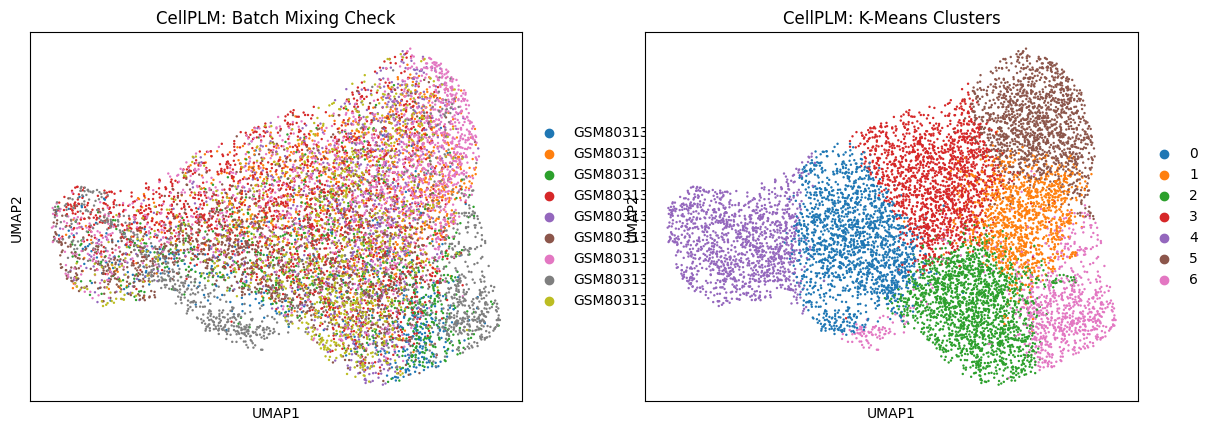

In [12]:
# Compute the Nearest-Neighbor Graph on CellPLM Embeddings

# This graph is the foundational structure required for UMAP
# We use the CellPLM embeddings as input for this structure.
sc.pp.neighbors(
    adata, 
    use_rep='X_cellplm',  # Correct input
    n_neighbors=15 
)

print("CellPLM Nearest-Neighbor Graph complete.")

# UMAP Projection, Clustering (K-Means), and Validation Plot

# K-Means Clustering

# Use the CellPLM embeddings as input
X_input = adata.obsm['X_cellplm']

n_clusters_to_use = 7 

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=n_clusters_to_use, random_state=0, n_init='auto')

# Store results in a UNIQUE column for CellPLM
adata.obs['kmeans_cellplm'] = kmeans.fit_predict(X_input).astype(str) 

print(f"CellPLM K-Means clustering complete with {n_clusters_to_use} clusters.")

# Run UMAP
# UMAP relies on the CellPLM-based Graph calculated above
sc.tl.umap(adata)

# Generate Validation Plot
sc.pl.umap(
    adata, 
    # CRITICAL FIX: Color by the NEW 'kmeans_cellplm' column, not the old 'kmeans'
    color=['batch', 'kmeans_cellplm'], 
    ncols=2,
    # Update filename to avoid overwriting the Harmony plot
    save='_kmeans_cellplm_validation.png', 
    title=['CellPLM: Batch Mixing Check', 'CellPLM: K-Means Clusters']
)

### 5. Load JSON Files

The provided JSON files contain the spatial metadata for every Visium spot on each slide, including coordinates and whether the spot actually overlaps tissue. Some spots fall on empty areas of the slide and have no meaningful expression data. After loading the JSON files, we keep only the spots marked as tissue=True so downstream analysis focuses on real biological material.

Filtering to tissue-only spots also ensures that the remaining rows line up with the expression matrix, meaning each spatial entry corresponds directly to the same spot in the data.

In [9]:
# Load JSON Files — Spatial Coordinates and Metadata Per Spot

import gzip, json, pandas as pd
from pathlib import Path

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

json_dir = Path(data_dir)
json_files = sorted(json_dir.glob("*.json.gz"))

coords_list = []

for file_path in json_files:
    sample_id = file_path.stem.split("_")[0]  # e.g. GSM8031360
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        oligos = pd.DataFrame(data["oligo"])
        oligos["sample_id"] = sample_id
        coords_list.append(oligos)

coords_df = pd.concat(coords_list, ignore_index=True)
coords_df = coords_df.rename(columns={"imageX": "x_coord", "imageY": "y_coord"})

coords_df.head()

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
0,4825,30073,0,0,53.25297,5938.0490,5803.2710,NaN,GSM8031361
1,4875,30160,1,1,53.25297,5866.8457,5762.1787,NaN,GSM8031361
2,4925,30073,0,2,53.25297,5938.1963,5721.3433,NaN,GSM8031361
3,4975,30160,1,3,53.25297,5866.9937,5680.2510,NaN,GSM8031361
4,5025,30073,0,4,53.25297,5938.3440,5639.4160,NaN,GSM8031361


In [13]:
# Filter out spots that do not actually contain tissue.
# 'tissue=True' marks spots where RNA was captured, so keeping only these
# ensures we work with meaningful spatial data

coords_tissue = coords_df[coords_df["tissue"] == True].copy()

print("Coords Tissue Shape:", coords_tissue.shape)
coords_tissue.head()

Coords Tissue Shape: (9989, 9)


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
1303,5975,31900,21,23,53.25297,4442.9326,4858.4043,True,GSM8031361
1304,6025,31813,20,24,53.25297,4514.2837,4817.5690,True,GSM8031361
1305,6075,31900,21,25,53.25297,4443.0806,4776.4766,True,GSM8031361
1306,6125,31813,20,26,53.25297,4514.4310,4735.6416,True,GSM8031361
1307,6175,31900,21,27,53.25297,4443.2285,4694.5493,True,GSM8031361


In [14]:
# Ensure the number of spots matches exactly before merging
if adata.n_obs != coords_tissue.shape[0]:
    print(f"Mismatch: AnnData has {adata.n_obs} spots, but Coords has {coords_tissue.shape[0]}.")
    print("Please ensure both are sorted by Sample ID before merging.")
else:
    print(f"Spot counts match ({adata.n_obs}). Proceeding with merge...")

    # Assign Spatial Coordinates
    # T ake the x and y image coordinates from the dataframe
    # AnnData expects this as a numpy array in .obsm['spatial']
    adata.obsm['spatial'] = coords_tissue[['x_coord', 'y_coord']].values

    # Add other metadata from the JSONs to adata.obs
    adata.obs['array_row'] = coords_tissue['row'].values
    adata.obs['array_col'] = coords_tissue['col'].values

    print("Spatial coordinates successfully added to adata.obsm['spatial'].")

Spot counts match (9989). Proceeding with merge...
Spatial coordinates successfully added to adata.obsm['spatial'].


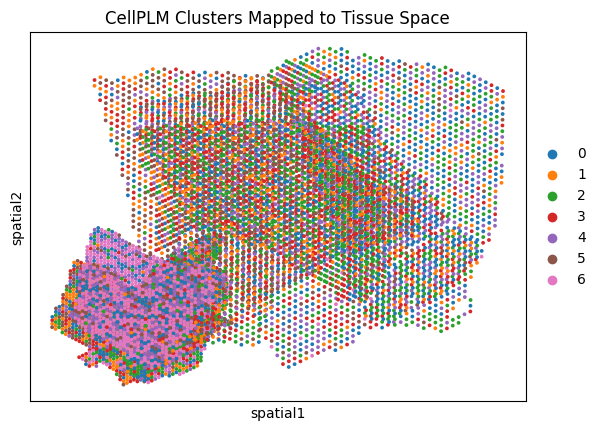

In [ ]:
# Spatial Visualization of CellPLM Clusters

# We use 'embedding' with basis='spatial' to plot the coordinates loaded manually.
sc.pl.embedding(
    adata,
    basis="spatial",
    color="kmeans_cellplm", 
    size=30, # Note: parameter is 'size', not 'spot_size' for embeddings
    title="CellPLM Clusters Mapped to Tissue Space",
    save="_cellplm_spatial_map.png"
)
